In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from ray import tune
from torch.utils.data import DataLoader, TensorDataset #, Dataset
# import torch.nn.functional as F

import wandb
import os
from sklearn.decomposition import PCA
import GPUtil
import itertools
import io

from collections import Counter
from sklearn.preprocessing import StandardScaler

# Data Loading and Setup:
---

In [3]:
# Loading Data:
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_data.csv'
train = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_data.csv'
val = pd.read_csv(file_path)
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_data.csv'
# test = pd.read_csv(file_path)


file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

In [33]:
train.head()

,Unnamed: 0,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,272149,1297539,94.0,96.0,99.0,101.0,105.0,109.0,115.0,120.0,...,-5.0,DtBP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,293336,1344903,108.0,112.0,117.0,122.0,128.0,133.0,138.0,145.0,...,-4.0,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,240982,1221071,116.0,122.0,130.0,135.0,143.0,150.0,159.0,167.0,...,3.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,226406,1173350,95.0,101.0,106.0,112.0,119.0,124.0,128.0,132.0,...,-3.0,DtBP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,311847,1416666,105.0,109.0,114.0,119.0,125.0,131.0,138.0,143.0,...,-20.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## GPU Setup:
---

In [5]:
if torch.cuda.is_available():
    # Get the list of GPUs
    gpus = GPUtil.getGPUs()

    # Find the GPU with the most free memory
    best_gpu = max(gpus, key=lambda gpu: gpu.memoryFree)

    # Print details about the selected GPU
    print(f"Selected GPU ID: {best_gpu.id}")
    print(f"  Name: {best_gpu.name}")
    print(f"  Memory Free: {best_gpu.memoryFree} MB")
    print(f"  Memory Used: {best_gpu.memoryUsed} MB")
    print(f"  GPU Load: {best_gpu.load * 100:.2f}%")

    # Set the device for later use
    device = torch.device(f'cuda:{best_gpu.id}')
    print('Current device ID: ', device)

    # Set the current device in PyTorch
    torch.cuda.set_device(best_gpu.id)
else:
    device = torch.device('cpu')
    print('Using CPU')

# Confirm the currently selected device in PyTorch
print("PyTorch current device ID:", torch.cuda.current_device())
print("PyTorch current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Selected GPU ID: 1
  Name: NVIDIA GeForce RTX 4090
  Memory Free: 24203.0 MB
  Memory Used: 14.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:1
PyTorch current device ID: 1
PyTorch current device name: NVIDIA GeForce RTX 4090


## WandB Setup:
---

In [6]:
# os.environ['WANDB_API_KEY'] = '9729ad7b1f3a60f1072cdf7af979b737955733d4'
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = '/home/cmdunham/ChemicalDataGeneration/models/ims_generator.ipynb'

In [7]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

## Embeddings:
---

In [8]:
# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


In [9]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

## Spectra:
---

In [10]:
# drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
train_spectra = train.iloc[:,2:-9]
train_chem_encodings = train.iloc[:,-8:]

val_spectra = val.iloc[:,2:-9]
val_chem_encodings = val.iloc[:,-8:]

# create tensors of spectra, true embeddings, and chemical name encodings for train and val
train_chem_labels = list(train['Label'])
train_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in train_chem_labels]).to(device)
train_spectra_tensor = torch.Tensor(train_spectra.values).to(device)
train_chem_encodings_tensor = torch.Tensor(train_chem_encodings.values).to(device)

val_chem_labels = list(val['Label'])
val_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in val_chem_labels]).to(device)
val_spectra_tensor = torch.Tensor(val_spectra.values).to(device)
val_chem_encodings_tensor = torch.Tensor(val_chem_encodings.values).to(device)

## Spectra Plotting:

In [31]:
def plot_spectra_pca(spectra, chemical_names):
    """
    Plots the PCA of given spectra and visualizes the results in a 2D 
    scatter plot. Each point in the plot represents a spectrum, 
    colored according to its associated chemical name.

    Parameters:
    ----------
    spectra : array-like, shape (n_samples, n_features)
        A 2D array of spectral data where each row corresponds to a sample and 
        each column corresponds to a feature.

    chemical_names : list of str, len (n_samples)
        A list of chemical names corresponding to each spectrum.

    Returns:
    -------
    None : The function displays a scatter plot and does not return any value.
    """

    pca = PCA(n_components=2)
    transformed_spectra = pca.fit_transform(spectra)

    # Create a color map where each chemical name is assigned a unique integer
    unique_chemical_names = list(set(chemical_names))
    color_map = {chem: idx for idx, chem in enumerate(unique_chemical_names)}
    # color_map = {chem: idx for idx, chem in enumerate(chemical_names)}

    # Map chemical names to their respective colors 
    colors = [color_map[chem] for chem in chemical_names]

    # Extract the x and y coordinates from the transformed spectra
    true_x = [pair[0] for pair in transformed_spectra]
    true_y = [pair[1] for pair in transformed_spectra]
    scatter = plt.scatter(true_x, true_y, c=colors, cmap='tab20')

    # Add a legend to the plot
    plt.legend(handles=scatter.legend_elements()[0],
                labels=unique_chemical_names,
                loc='upper right',
                prop={'size':7})

    plt.title('Train Spectra PCA', fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.show()

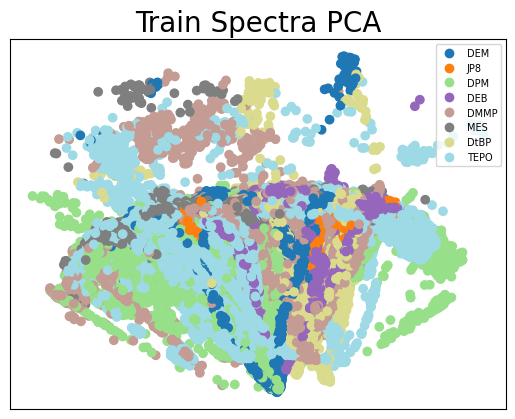

In [32]:
plot_spectra_pca(train_spectra, train_chem_labels)

# Definitions:
---

In [128]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(512,652),
      nn.LeakyReLU(inplace=True),
      nn.Linear(652,780),
      nn.LeakyReLU(inplace=True),
      nn.Linear(780, 908),
      nn.LeakyReLU(inplace=True),
      nn.Linear(908, 1036),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1036, 1164),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1164, 1292),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1292, 1420),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1420, 1548),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1548, 1676),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [154]:
class TruncatedDataGenerator(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(512,652),
      nn.LeakyReLU(inplace=True),
      nn.Linear(652,780),
      nn.LeakyReLU(inplace=True),
      nn.Linear(780, 908),
      nn.LeakyReLU(inplace=True),
      nn.Linear(908, 1036),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1036, 1032),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [129]:
def train_one_epoch(train_dataset, device, model, criterion, optimizer, epoch, combo):
  epoch_training_loss = 0

  predicted_spectra = []
  output_name_encodings = []
  original_spectra = []

  for true_spectra, name_encodings, true_embeddings in train_dataset:
    # move inputs to device
    true_spectra = true_spectra.to(device)
    name_encodings = name_encodings.to(device)
    true_embeddings = true_embeddings.to(device)

    # backprapogation
    optimizer.zero_grad()

    # forward pass
    batch_predicted_spectra = model(true_embeddings)

    loss = criterion(batch_predicted_spectra, true_spectra)
    # accumulate epoch training loss
    epoch_training_loss += loss.item()

    loss.backward()
    optimizer.step()

    # at last epoch store output embeddings and corresponding labels to output list
    if (epoch + 1) == combo['epochs']:
      for enc, spec, true_spec in zip(name_encodings, batch_predicted_spectra, true_spectra):
        output_name_encodings.append(enc.cpu().detach().numpy())
        predicted_spectra.append(spec.cpu().detach().numpy())
        original_spectra.append(true_spec.cpu().detach().numpy())

  # divide by number of batches to calculate average loss
  average_loss = epoch_training_loss/len(train_dataset)
  if (epoch + 1) == combo['epochs']:
    return average_loss, predicted_spectra, output_name_encodings, original_spectra
  else:
    return average_loss

In [144]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))
  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [131]:
def plot_results(real_spectra, fake_spectra, chem_encodings, sorted_chem_names, plotting_chem='all', log_wandb=True, idx=[0,5]):
  """
  Plot and compare real and synthetic spectra within a specified index range.

  Takes in real and synthetic spectra and plots them for comparison.
  Computes and prints the weighted cosine similarity between the real spectrum synthetic spectrum.

  Args:
      real_spectra (list of list of float): List of real spectra, where each spectrum is a list of intensity values.
      fake_spectra (list of list of float): List of synthetic spectra generated by decoder.
      labels (list of str): List of chemical name labels corresponding to each spectrum.
      idx (list of int, optional): Range of indices to plot. Default is [0, 5].
  """
  labels = [sorted_chem_names[list(encoding).index(1)] for encoding in chem_encodings]

  start_num = idx[0]
  stop_num = idx[1]
  
  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plot spectra within the specified index range
    if i > stop_num:
      break
    if start_num <= i < stop_num:
      # if a specific chemical has been specified only plot spectra for that chemical 
      if plotting_chem != 'all':
        if labels[i] != plotting_chem:
          stop_num +=1
          continue
          
      # Define the x-axis range
      numbers = range(0, len(real_spec)//2)

      # Scale the real spectrum so highest peak is 100
      true_spectra_copy = real_spec.copy()

      # Scale the synthetic spectrum so highest peak is 100
      synthetic_spectra_copy = fake_spec.copy()

      weighted_cosine_similarity = get_weighted_cosine_similarity(synthetic_spectra_copy, true_spectra_copy)

      # Create a plot with 2 subplots for real and synthetic spectra
      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].plot(numbers, true_spectra_copy[:len(numbers)], label='Positive')
      ax[0].plot(numbers, true_spectra_copy[len(numbers):], label='Negative')
      ax[0].set_title(f'True {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].plot(numbers, synthetic_spectra_copy[:len(numbers)], label='Positive')
      ax[1].plot(numbers, synthetic_spectra_copy[len(numbers):], label='Negative')
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity between true spectra and output spectra is: ', round(float(weighted_cosine_similarity), 2))
      ax[1].set_xlabel('Drift Time', fontsize=16)
      ax[1].set_ylabel('Ion Intensity', fontsize=16)

      if log_wandb:
        plt.savefig('tmp_plot.png', format='png', dpi=300)
        wandb.log({'Comparison of Experimental and Synthetic Spectra': wandb.Image('tmp_plot.png')})

      plt.tight_layout()
      plt.show()

# Running the Generator:
---

## Model Training:
---

In [ ]:
# set var deciding if results plot for this run is saved to wandb
log_wandb = True
# simulant to plot results for. It can be useful to see comparisons for the same simulant
plotting_chem = 'TEPO'

# Last 8 cols of the df are the chem names
sorted_chem_names = list(train.columns[-8:])

# model_config = {
#   'batch_size':[128, 256],
#   'epochs': [100],
#   'learning_rate':[.01, .001]
  # }

# loss to compare for each model. Starting at something high so it will be replaced by first model's loss 
lowest_loss = 10000000

model_config = {
    'batch_size': [128],
    'epochs': [100],
    'learning_rate': [.001]
}

keys = model_config.keys()
values = model_config.values()

# Generate all parameter combinations from model_config using itertools.product
combinations = itertools.product(*values)

# Iterate through each parameter combination and run model 
for combo in combinations:
  combo = dict(zip(keys, combo))

  train_dataset = DataLoader(TensorDataset(train_spectra_tensor, train_chem_encodings_tensor, train_embeddings_tensor), batch_size=combo['batch_size'], shuffle=True)
  val_dataset = DataLoader(TensorDataset(val_spectra_tensor, val_chem_encodings_tensor, val_embeddings_tensor), batch_size=combo['batch_size'], shuffle=False)
  generator = Generator().to(device)

  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr = combo['learning_rate'])
  generator_criterion = nn.MSELoss()

  wandb_kwargs = {
    'learning_rate': combo['learning_rate'],
    'epochs': combo['epochs'],
    'batch_size': combo['batch_size'],
    'model_architecture': 'generator',
    'optimizer':'AdamW',
    'loss': 'MSELoss'
  }

  run_with_wandb(config, **wandb_kwargs)

  print('--------------------------')
  print('--------------------------')
  print('New run with hyperparameters:')
  for key in combo:
    print(key, ' : ', combo[key])
  print('--------------------------')
  print('--------------------------')

  for epoch in range(combo['epochs']):
    # Set model to training mode
    generator.train(True)

    # do a pass over the data
    # at last epoch get predicted embeddings and chem names
    if (epoch + 1) == combo['epochs']:
      average_loss, predicted_spectra, output_name_encodings, original_spectra = train_one_epoch(
        train_dataset, device, generator, generator_criterion, generator_optimizer, epoch, combo
        )
    else:
      average_loss = train_one_epoch(
        train_dataset, device, generator, generator_criterion, generator_optimizer, epoch, combo
        )

    epoch_val_loss = 0  
    # evaluate model on validation data
    generator.eval() # Set model to evaluation mode
    with torch.no_grad():
      for val_true_spectra, val_name_encodings, val_true_embeddings in val_dataset:
        val_true_spectra = val_true_spectra.to(device)
        val_name_encodings = val_name_encodings.to(device)
        val_true_embeddings = val_true_embeddings.to(device)

        val_batch_predicted_spectra = generator(val_true_embeddings)

        val_loss = generator_criterion(val_batch_predicted_spectra, val_true_spectra)
        # accumulate epoch validation loss
        epoch_val_loss += val_loss.item()

    # divide by number of batches to calculate average loss
    val_average_loss = epoch_val_loss/len(val_dataset)

    # log losses to wandb
    wandb.log({"Generator Training Loss": average_loss, "Generator Validation Loss": val_average_loss})

    if (epoch + 1) % 10 == 0:
      print('Epoch[{}/{}]:'.format(epoch+1, combo['epochs']))
      print(f'   Training loss: {average_loss}')
      print(f'   Validation loss: {val_average_loss}')
      print('-------------------------------------------')

  # saving comparison plots for first 5 spectra
  plot_results(original_spectra, predicted_spectra, output_name_encodings, sorted_chem_names, plotting_chem, log_wandb, idx=[0,5])

  if average_loss < lowest_loss:
    lowest_loss = average_loss
    best_hyperparams = combo

  wandb.finish()

print('Hyperparameters for best model: ')
for key in best_hyperparams:
  print('   ', key, ' : ', best_hyperparams[key])

## Fine Tuning on a Single Chemical:
---

In [133]:
# drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
single_chem_train = train[train['Label'] == 'TEPO']
single_chem_train_spectra = single_chem_train.iloc[:,2:-9]
single_chem_train_chem_encodings = single_chem_train.iloc[:,-8:]

single_chem_val = val[val['Label'] == 'TEPO']
single_chem_val_spectra = single_chem_val.iloc[:,2:-9]
single_chem_val_chem_encodings = single_chem_val.iloc[:,-8:]

# create tensors of spectra, true embeddings, and chemical name encodings *for single chemical* for train and val
single_chem_train_chem_labels = list(single_chem_train['Label'])
single_chem_train_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in single_chem_train_chem_labels]).to(device)
single_chem_train_spectra_tensor = torch.Tensor(single_chem_train_spectra.values).to(device)
single_chem_train_chem_encodings_tensor = torch.Tensor(single_chem_train_chem_encodings.values).to(device)

single_chem_val_chem_labels = list(single_chem_val['Label'])
single_chem_val_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in single_chem_val_chem_labels]).to(device)
single_chem_val_spectra_tensor = torch.Tensor(single_chem_val_spectra.values).to(device)
single_chem_val_chem_encodings_tensor = torch.Tensor(single_chem_val_chem_encodings.values).to(device)

In [ ]:
# Freeze some layers of the generator to maintain some info learned during pre-training

# set number of layers of pre-trained model to freeze
num_freeze_layers = 3
for i, param in enumerate(generator.parameters()):
    if i < 3:
        # if i % 2 == 0:
        param.requires_grad = False

Single Chem Generator Training Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁
Single Chem Generator Validation Loss,▂▁▁▂▃▂▄▁▂▂▆▆▂▄▃█▃▁▇▂▇▂▂▂▄▁▃▆▆▂
Single Chem Generator Training Loss,163177.74471
Single Chem Generator Validation Loss,163293.98754


Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  128
epochs  :  30
learning_rate  :  0.001
--------------------------
--------------------------
Epoch[10/30]:
   Training loss: 163146.26424077182
   Validation loss: 163530.5625
-------------------------------------------
Epoch[20/30]:
   Training loss: 163129.07363674496
   Validation loss: 163246.80226934524
-------------------------------------------
Epoch[30/30]:
   Training loss: 163134.60920721476
   Validation loss: 164368.56575520834
-------------------------------------------
Weighted cosine similarity between true spectra and output spectra is:  0.95


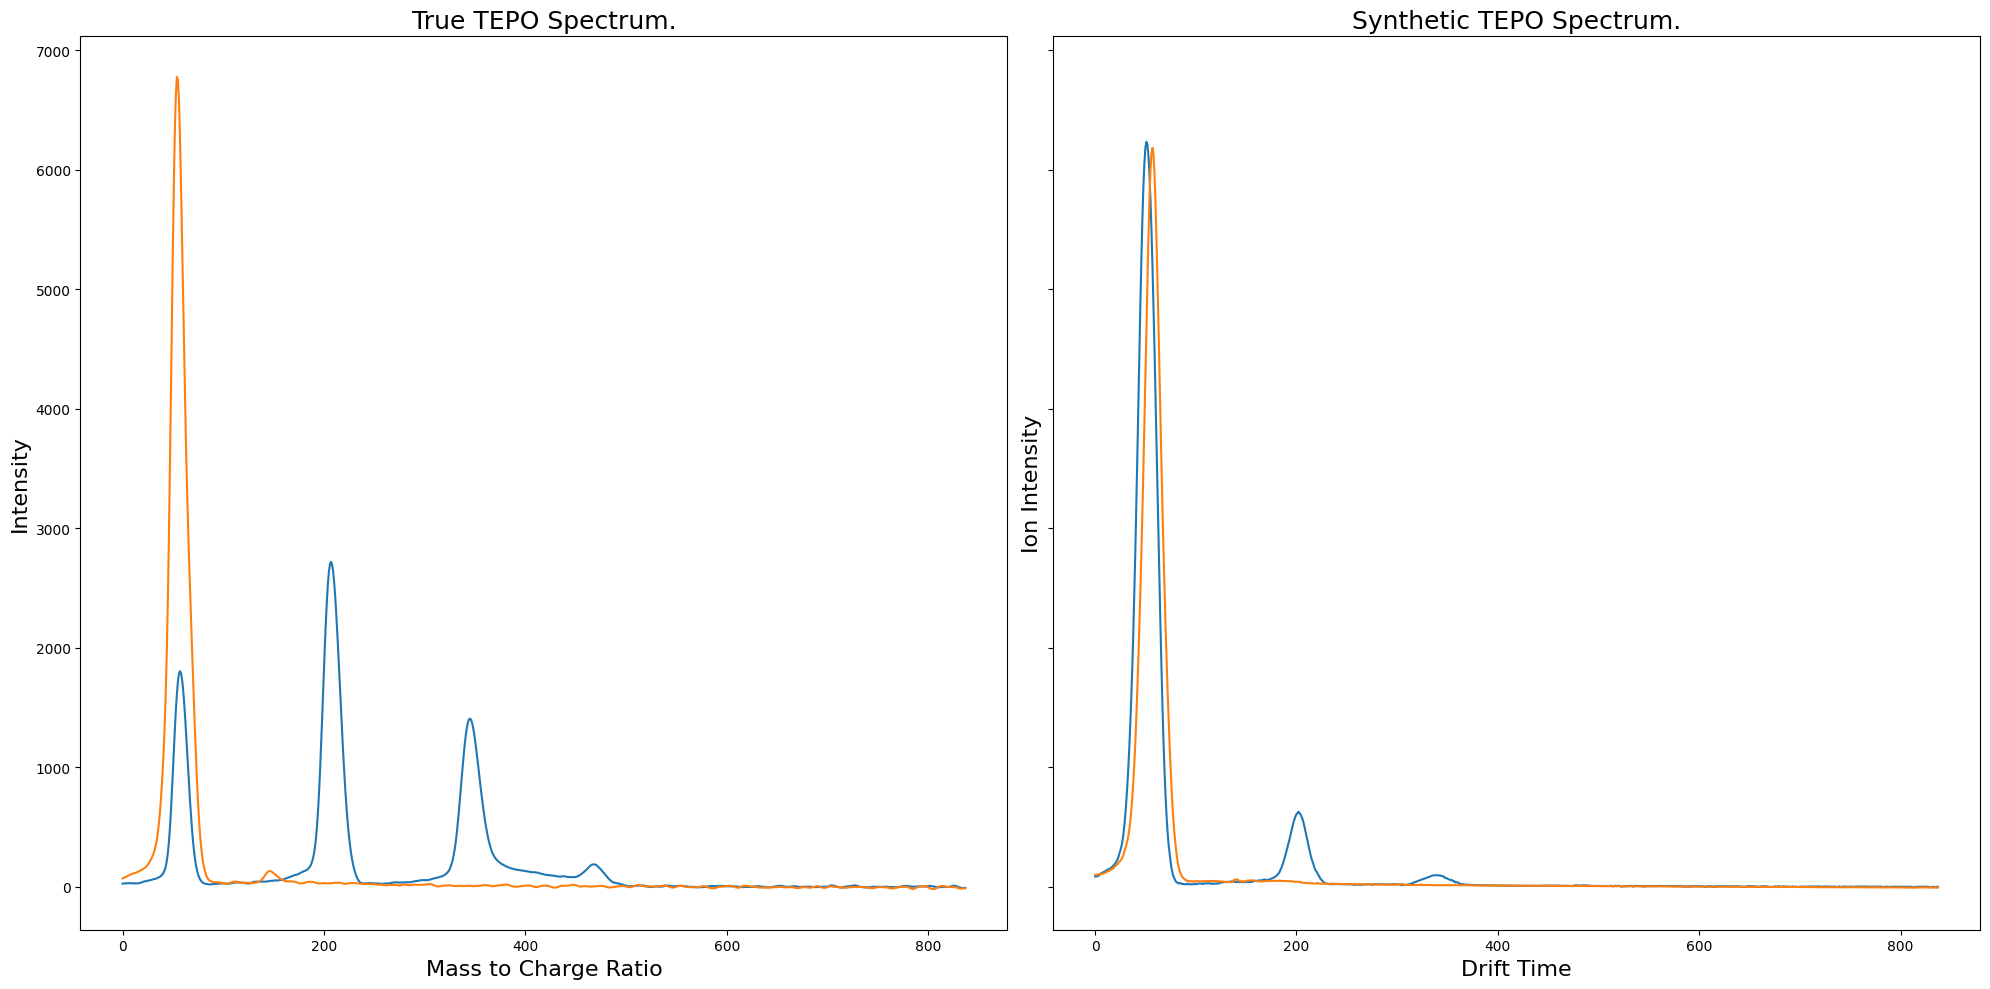

Weighted cosine similarity between true spectra and output spectra is:  0.95


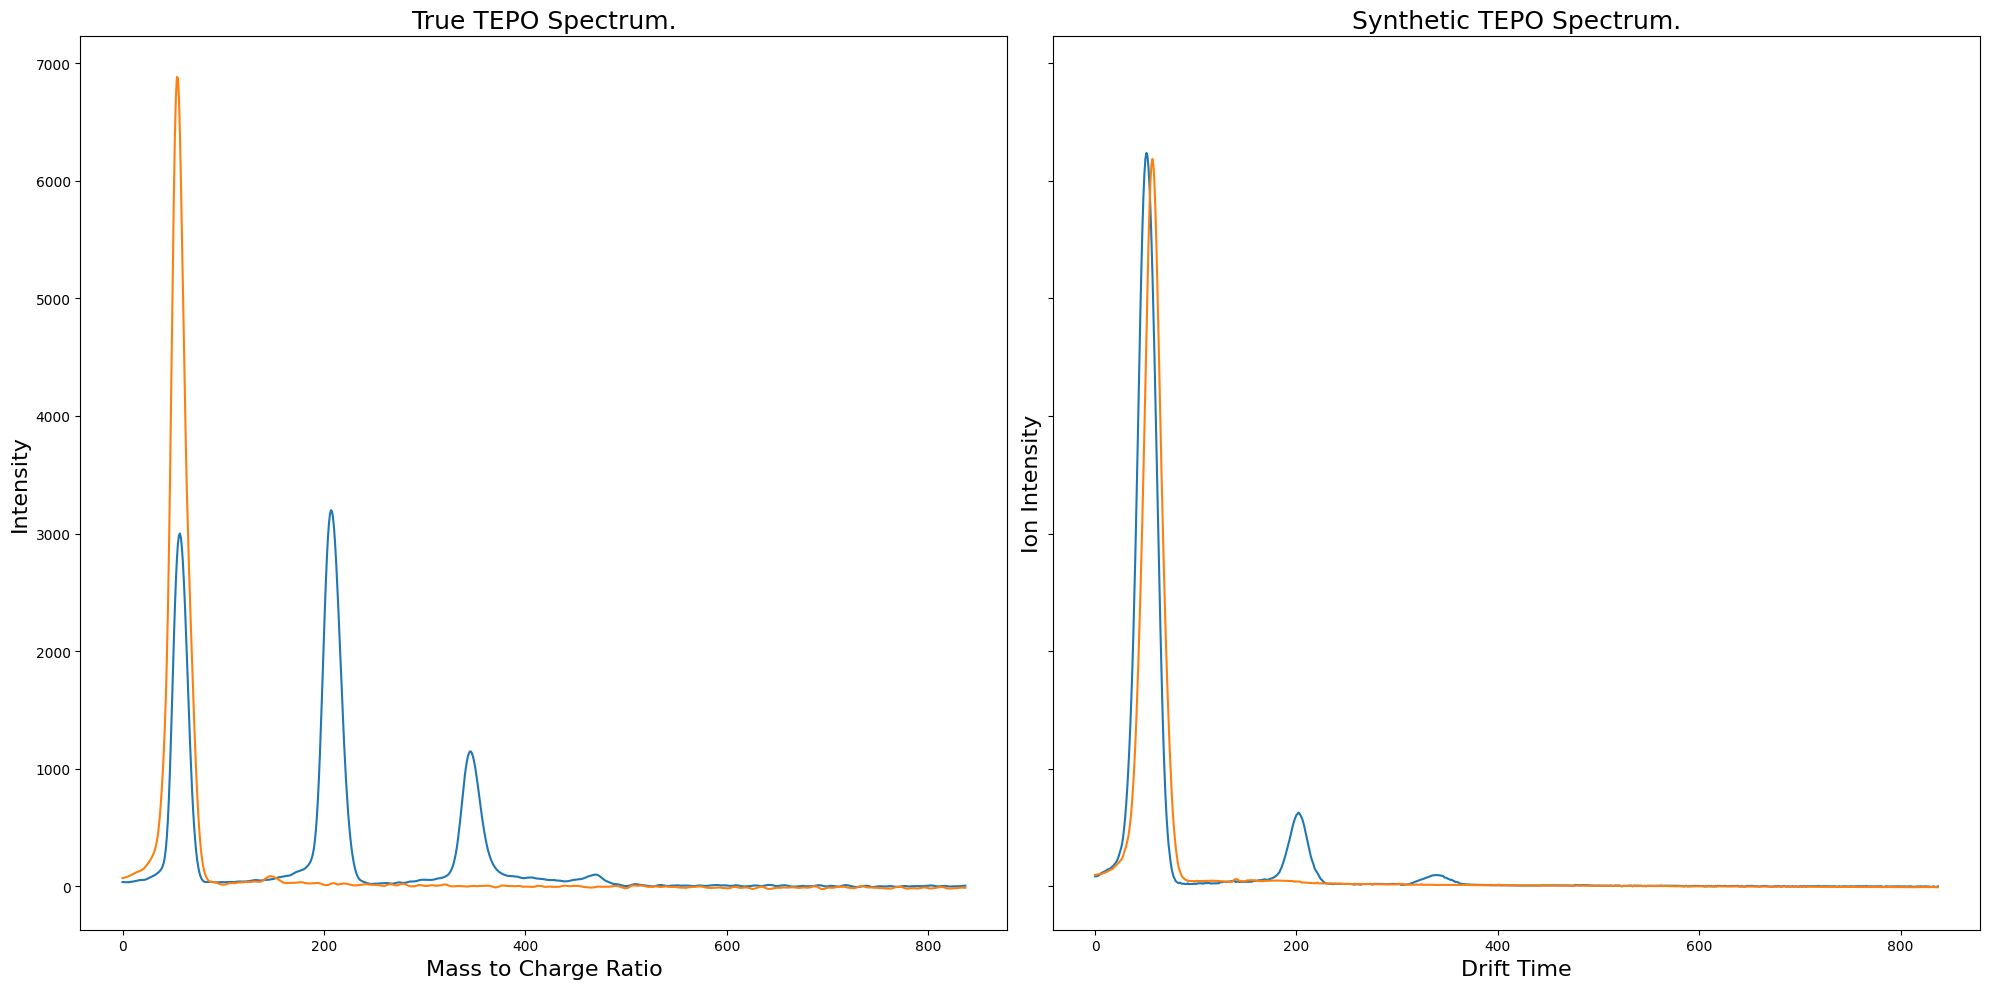

Weighted cosine similarity between true spectra and output spectra is:  0.71


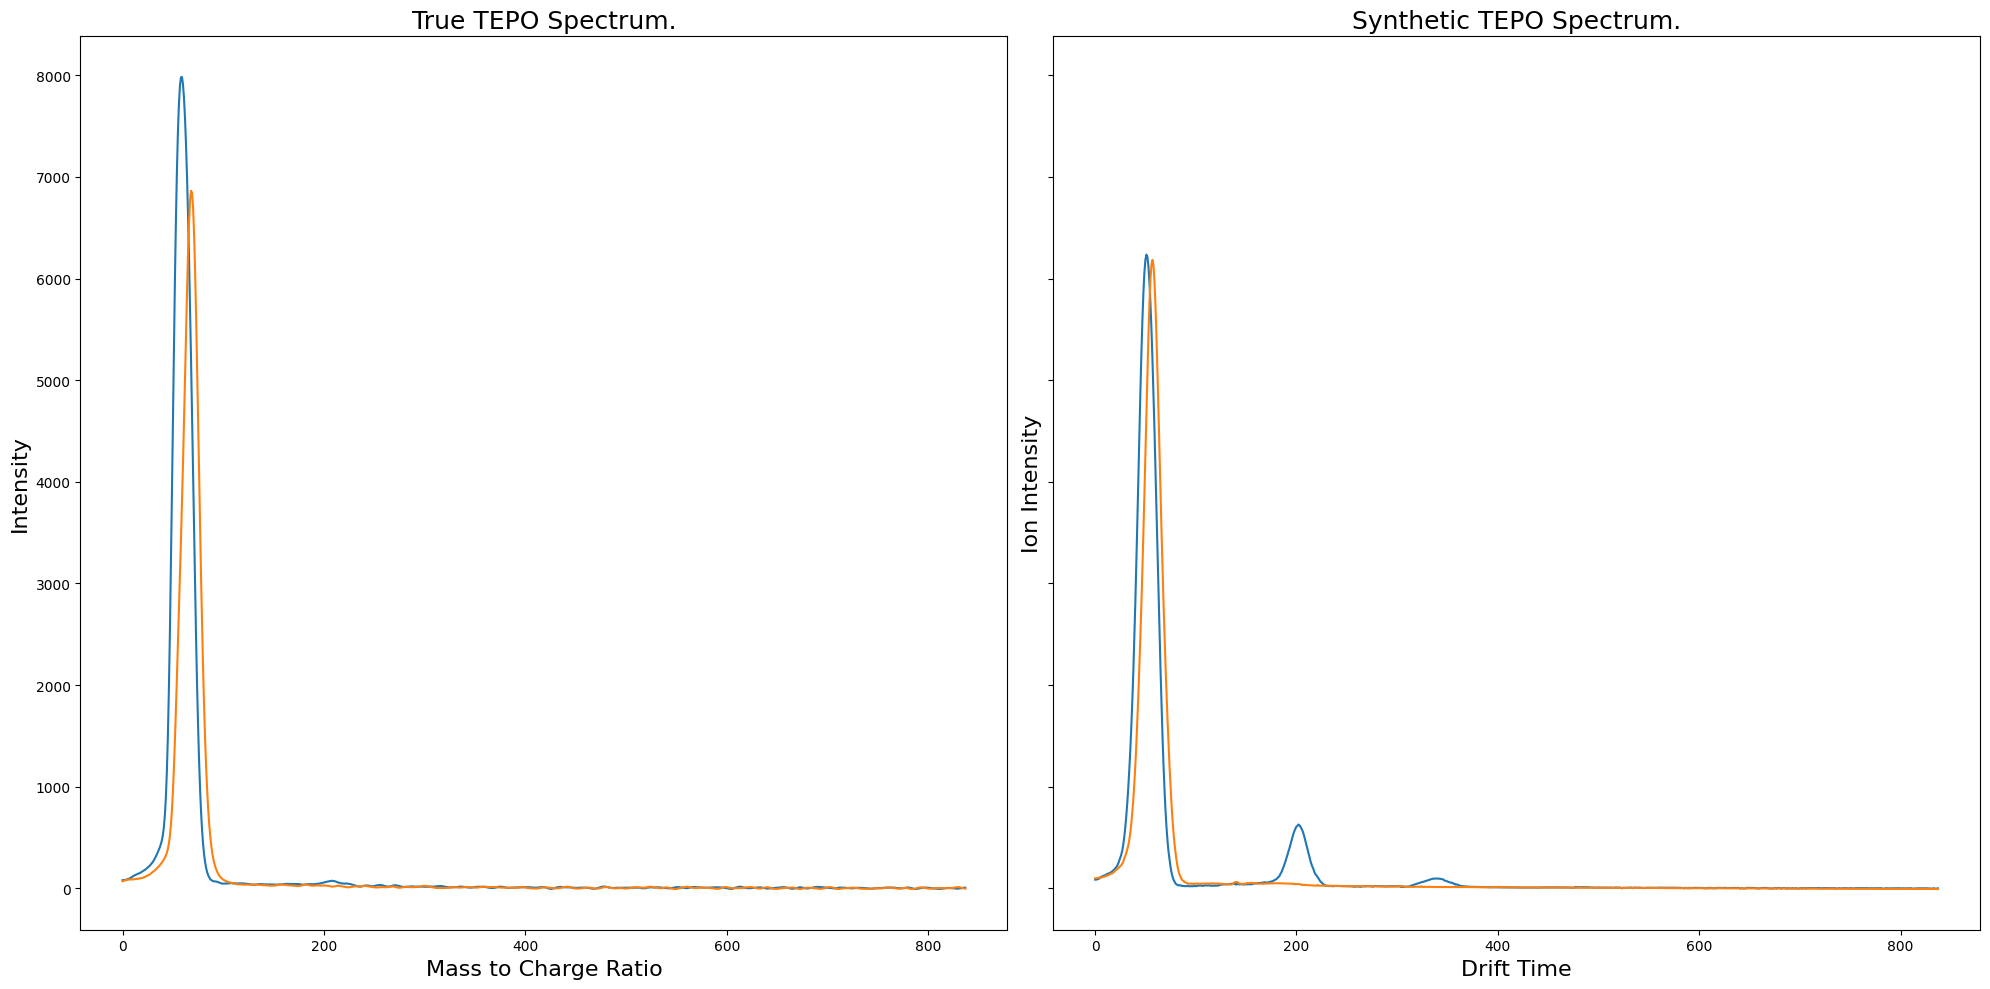

Weighted cosine similarity between true spectra and output spectra is:  0.8


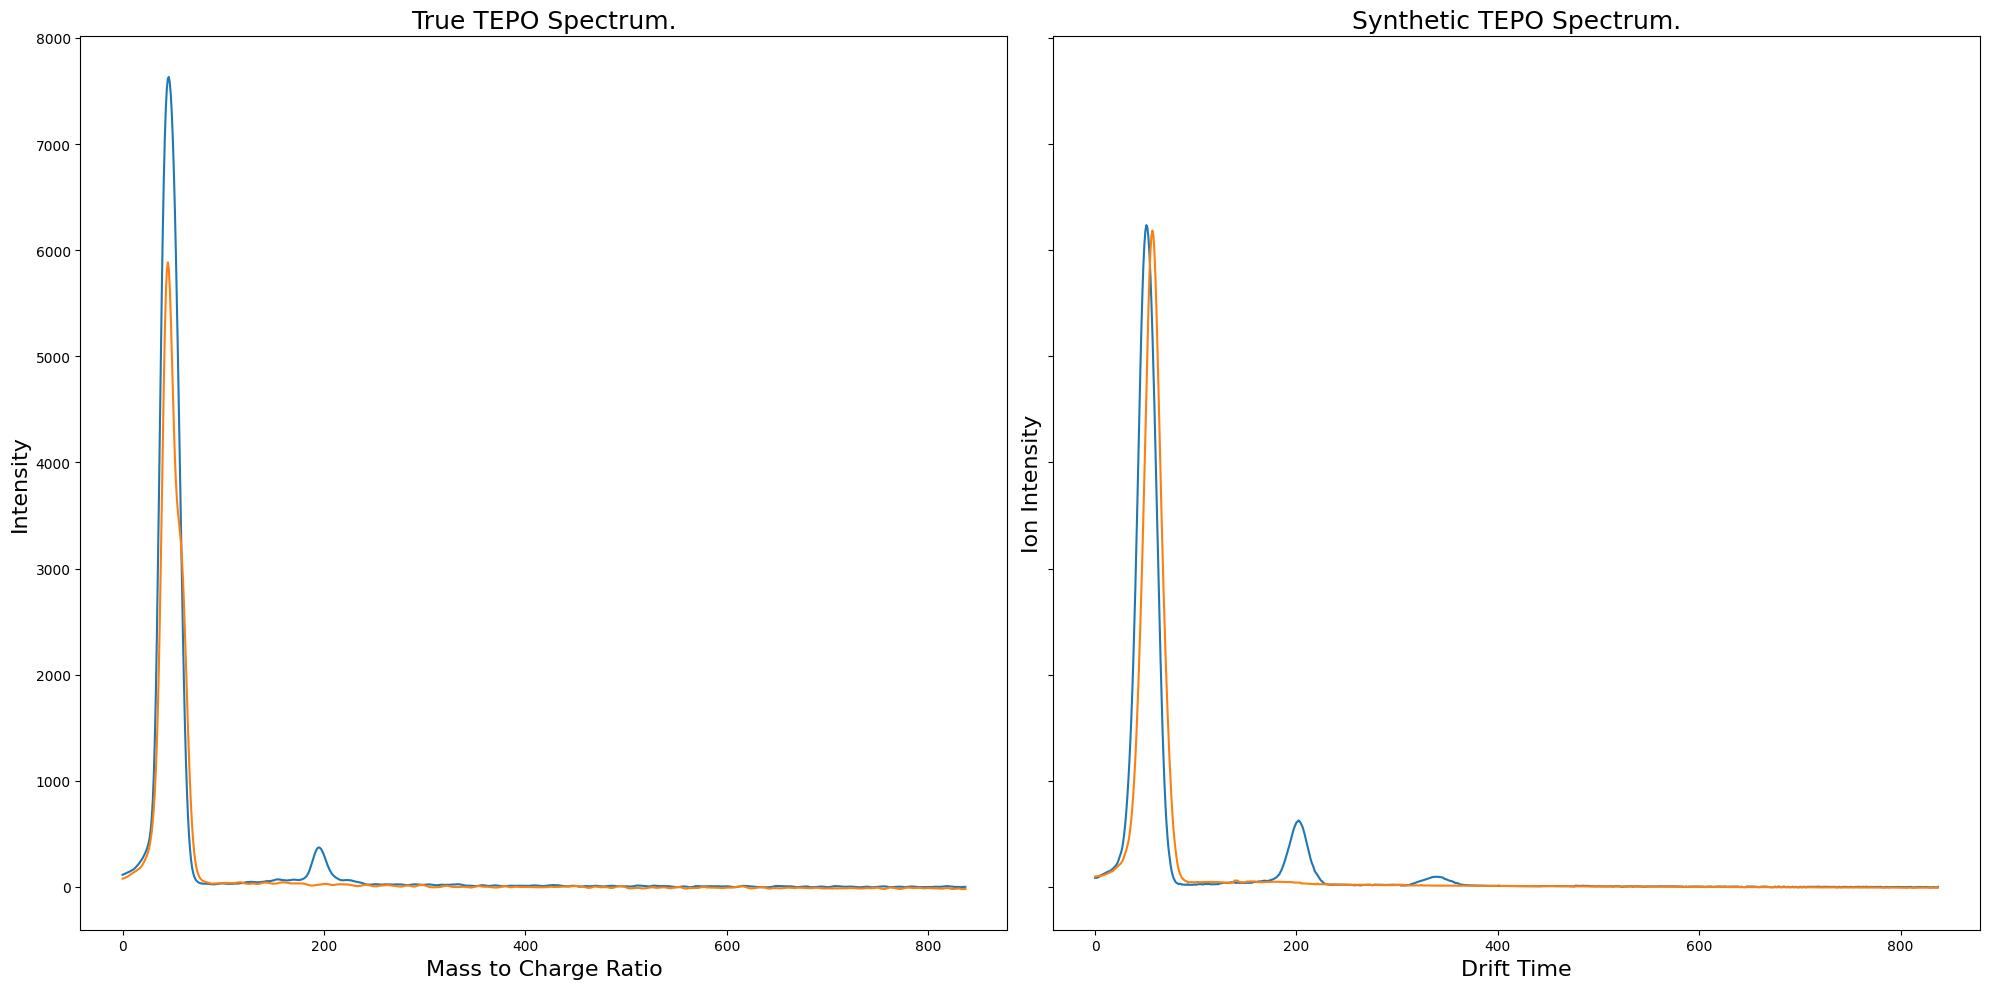

Weighted cosine similarity between true spectra and output spectra is:  0.79


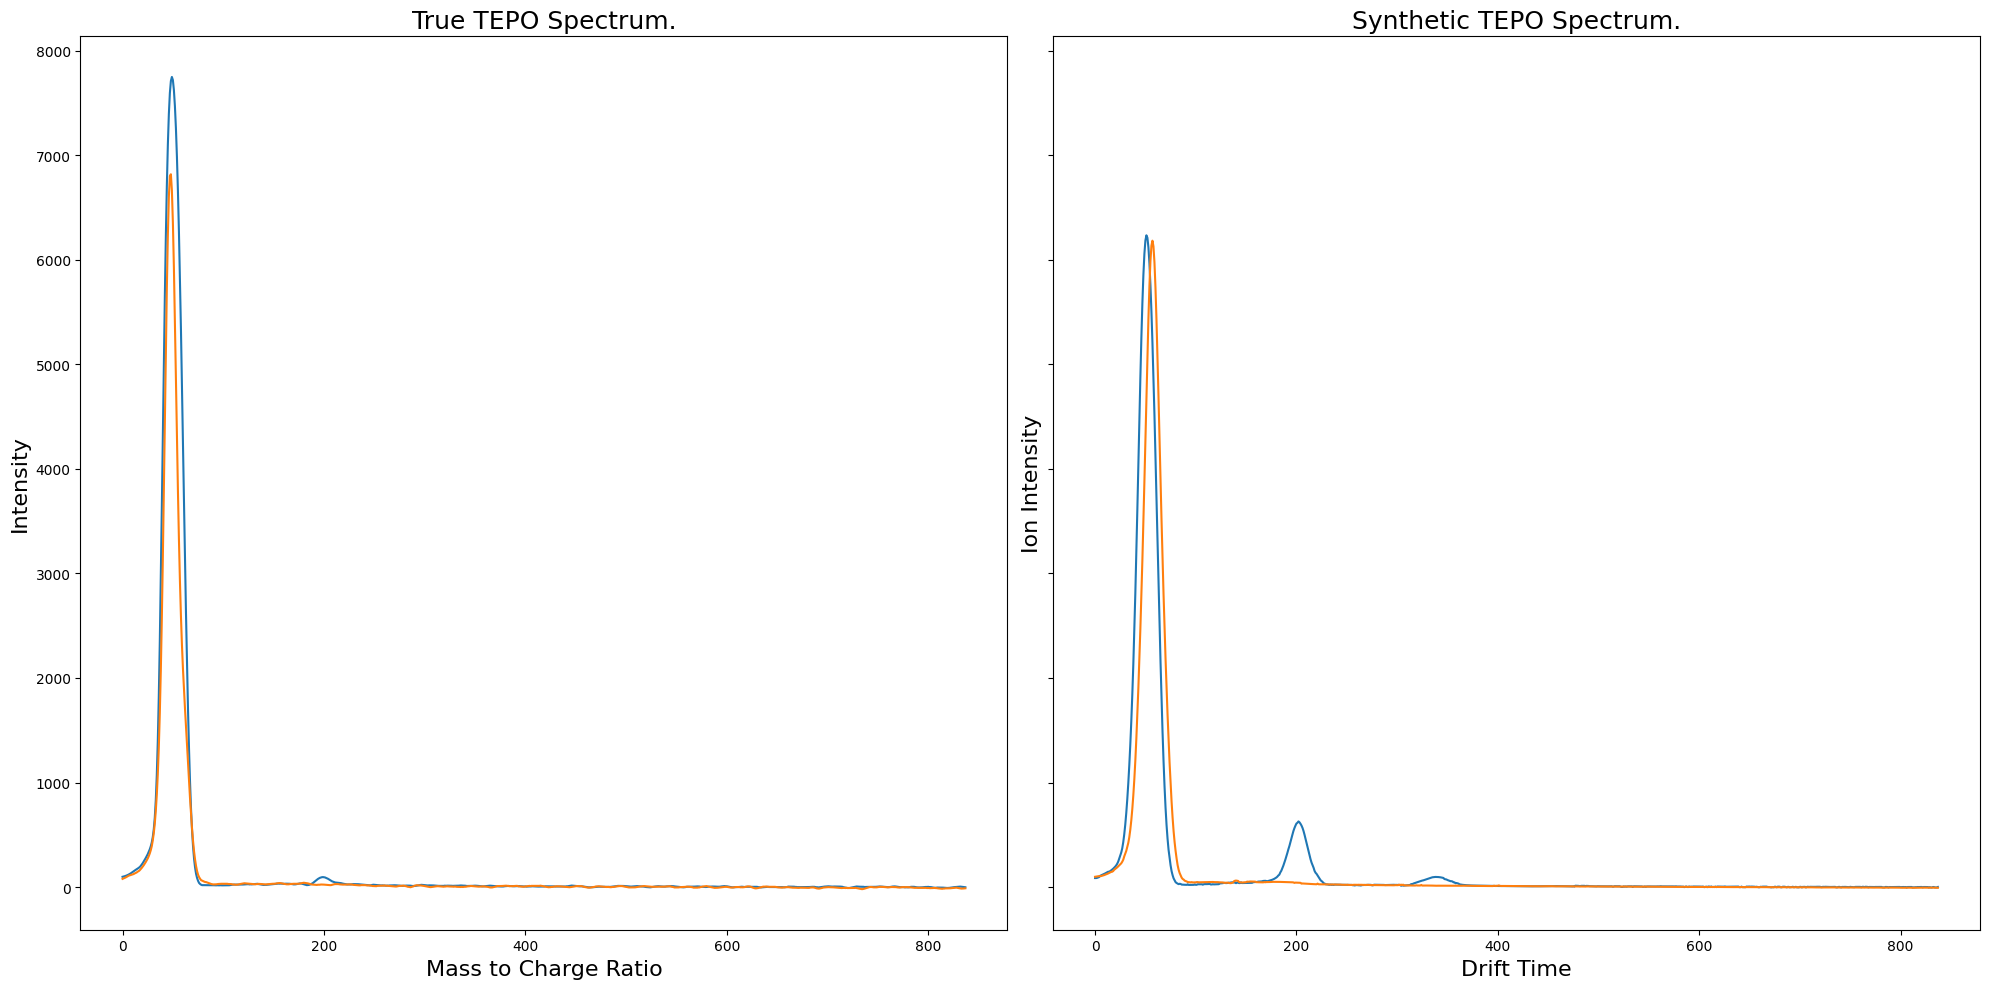

Generator Training Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
Generator Validation Loss,▂▁▁▃▂▃▅▁▂▃▁▂▃▁▃▂▁▂▂▁▂▂▅▂▁▁▁▅▅█
Generator Training Loss,163134.60921
Generator Validation Loss,164368.56576


Hyperparameters for best model: 
    batch_size  :  128
    epochs  :  30
    learning_rate  :  0.001


In [145]:
# set var deciding if results plot for this run is saved to wandb
log_wandb = True
# simulant to plot results for. It can be useful to see comparisons for the same simulant
plotting_chem = 'TEPO'

# Last 8 cols of the df are the chem names
sorted_chem_names = list(train.columns[-8:])

# model_config = {
#   'batch_size':[128, 256],
#   'epochs': [100],
#   'learning_rate':[.01, .001]
  # }

# loss to compare for each model. Starting at something high so it will be replaced by first model's loss 
lowest_loss = 10000000

model_config = {
    'batch_size': [128],
    'epochs': [30],
    'learning_rate': [.001]
}

keys = model_config.keys()
values = model_config.values()

# Generate all parameter combinations from model_config using itertools.product
combinations = itertools.product(*values)

# Iterate through each parameter combination and run model 
for combo in combinations:
  combo = dict(zip(keys, combo))

  train_dataset = DataLoader(TensorDataset(single_chem_train_spectra_tensor, single_chem_train_chem_encodings_tensor, single_chem_train_embeddings_tensor), batch_size=combo['batch_size'], shuffle=True)
  val_dataset = DataLoader(TensorDataset(single_chem_val_spectra_tensor, single_chem_val_chem_encodings_tensor, single_chem_val_embeddings_tensor), batch_size=combo['batch_size'], shuffle=False)

  wandb_kwargs = {
    'learning_rate': combo['learning_rate'],
    'epochs': combo['epochs'],
    'batch_size': combo['batch_size'],
    'model_architecture': 'single_chem_generator',
    'optimizer':'AdamW',
    'loss': 'MSELoss'
  }

  run_with_wandb(config, **wandb_kwargs)

  print('--------------------------')
  print('--------------------------')
  print('New run with hyperparameters:')
  for key in combo:
    print(key, ' : ', combo[key])
  print('--------------------------')
  print('--------------------------')

  for epoch in range(combo['epochs']):
    # Set model to training mode
    generator.train(True)

    # do a pass over the data
    # at last epoch get predicted embeddings and chem names
    if (epoch + 1) == combo['epochs']:
      average_loss, predicted_spectra, output_name_encodings, original_spectra = train_one_epoch(
        train_dataset, device, generator, generator_criterion, generator_optimizer, epoch, combo
        )
    else:
      average_loss = train_one_epoch(
        train_dataset, device, generator, generator_criterion, generator_optimizer, epoch, combo
        )

    epoch_val_loss = 0  
    # evaluate model on validation data
    generator.eval() # Set model to evaluation mode
    with torch.no_grad():
      for val_true_spectra, val_name_encodings, val_true_embeddings in val_dataset:
        val_true_spectra = val_true_spectra.to(device)
        val_name_encodings = val_name_encodings.to(device)
        val_true_embeddings = val_true_embeddings.to(device)

        val_batch_predicted_spectra = generator(val_true_embeddings)

        val_loss = generator_criterion(val_batch_predicted_spectra, val_true_spectra)
        # accumulate epoch validation loss
        epoch_val_loss += val_loss.item()

    # divide by number of batches to calculate average loss
    val_average_loss = epoch_val_loss/len(val_dataset)

    # log losses to wandb
    wandb.log({"Generator Training Loss": average_loss, "Generator Validation Loss": val_average_loss})

    if (epoch + 1) % 10 == 0:
      print('Epoch[{}/{}]:'.format(epoch+1, combo['epochs']))
      print(f'   Training loss: {average_loss}')
      print(f'   Validation loss: {val_average_loss}')
      print('-------------------------------------------')

  # saving comparison plots for first 5 spectra
  plot_results(original_spectra, predicted_spectra, output_name_encodings, sorted_chem_names, plotting_chem, log_wandb, idx=[0,5])

  if average_loss < lowest_loss:
    lowest_loss = average_loss
    best_hyperparams = combo

  wandb.finish()

print('Hyperparameters for best model: ')
for key in best_hyperparams:
  print('   ', key, ' : ', best_hyperparams[key])

## Truncating Spectra Before Tail:
---
EDA in the ims_encoder file showed that using p_700 and n_700 as cutoffs would retain the majority of the information in the spectra.

In [ ]:
# Removing p points after p_700

# getting indices for start and stop cols
cols = list(train.columns)
start_idx = cols.index('p_700')
# remove cols up to start of neg spectrum
end_idx = cols.index('n_184')

train_truncated_p = train.drop(train.columns[start_idx:end_idx], axis=1)
# repeating for val data, based on info learned from train
val_truncated_p = val.drop(val.columns[start_idx:end_idx], axis=1)

# verifying that cols p_700 and beyond were removed
train_truncated_p.iloc[:2,start_idx-2:start_idx+2]

,p_698,p_699,n_184,n_185
0,6.0,9.0,73.0,79.0
1,11.0,11.0,63.0,68.0


In [147]:
# Removing n points after n_700

# getting indices for start and stop cols
cols = list(train_truncated_p.columns)
start_idx = cols.index('n_700')
# remove cols up to Label
end_idx = cols.index('Label')

train_truncated = train_truncated_p.drop(train_truncated_p.columns[start_idx:end_idx], axis=1)
val_truncated = val_truncated_p.drop(val_truncated_p.columns[start_idx:end_idx], axis=1)

# verifying that cols n_700 and beyond were removed
train_truncated.iloc[:2,start_idx-2:start_idx+2]

,n_698,n_699,Label,DEB
0,5.0,4.0,DtBP,0.0
1,-11.0,-11.0,DMMP,0.0


In [ ]:
# drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
train_spectra = train_truncated.iloc[:,2:-9]
train_chem_encodings = train_truncated.iloc[:,-8:]

val_spectra = val_truncated.iloc[:,2:-9]
val_chem_encodings = val_truncated.iloc[:,-8:]

# create tensors of spectra, true embeddings, and chemical name encodings for train and val
train_chem_labels = list(train_truncated['Label'])
train_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in train_chem_labels]).to(device)
train_spectra_tensor = torch.Tensor(train_spectra.values).to(device)
train_chem_encodings_tensor = torch.Tensor(train_chem_encodings.values).to(device)

val_chem_labels = list(val_truncated['Label'])
val_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in val_chem_labels]).to(device)
val_spectra_tensor = torch.Tensor(val_spectra.values).to(device)
val_chem_encodings_tensor = torch.Tensor(val_chem_encodings.values).to(device)

In [ ]:
# set var deciding if results plot for this run is saved to wandb
log_wandb = True
# simulant to plot results for. It can be useful to see comparisons for the same simulant
plotting_chem = 'TEPO'

# Last 8 cols of the df are the chem names
sorted_chem_names = list(train.columns[-8:])

# model_config = {
#   'batch_size':[128, 256],
#   'epochs': [100],
#   'learning_rate':[.01, .001]
  # }

# loss to compare for each model. Starting at something high so it will be replaced by first model's loss 
lowest_loss = 10000000

model_config = {
    'batch_size': [128],
    'epochs': [30],
    'learning_rate': [.0001, .01]
}

keys = model_config.keys()
values = model_config.values()

# Generate all parameter combinations from model_config using itertools.product
combinations = itertools.product(*values)

# Iterate through each parameter combination and run model 
for combo in combinations:
  combo = dict(zip(keys, combo))

  train_dataset = DataLoader(TensorDataset(train_spectra_tensor, train_chem_encodings_tensor, train_embeddings_tensor), batch_size=combo['batch_size'], shuffle=True)
  val_dataset = DataLoader(TensorDataset(val_spectra_tensor, val_chem_encodings_tensor, val_embeddings_tensor), batch_size=combo['batch_size'], shuffle=False)
  generator = TruncatedDataGenerator().to(device)

  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr = combo['learning_rate'])
  generator_criterion = nn.MSELoss()

  wandb_kwargs = {
    'learning_rate': combo['learning_rate'],
    'epochs': combo['epochs'],
    'batch_size': combo['batch_size'],
    'model_architecture': 'generator',
    'optimizer':'AdamW',
    'loss': 'MSELoss'
  }

  run_with_wandb(config, **wandb_kwargs)

  print('--------------------------')
  print('--------------------------')
  print('New run with hyperparameters:')
  for key in combo:
    print(key, ' : ', combo[key])
  print('--------------------------')
  print('--------------------------')

  for epoch in range(combo['epochs']):
    # Set model to training mode
    generator.train(True)

    # do a pass over the data
    # at last epoch get predicted embeddings and chem names
    if (epoch + 1) == combo['epochs']:
      average_loss, predicted_spectra, output_name_encodings, original_spectra = train_one_epoch(
        train_dataset, device, generator, generator_criterion, generator_optimizer, epoch, combo
        )
    else:
      average_loss = train_one_epoch(
        train_dataset, device, generator, generator_criterion, generator_optimizer, epoch, combo
        )

    epoch_val_loss = 0  
    # evaluate model on validation data
    generator.eval() # Set model to evaluation mode
    with torch.no_grad():
      for val_true_spectra, val_name_encodings, val_true_embeddings in val_dataset:
        val_true_spectra = val_true_spectra.to(device)
        val_name_encodings = val_name_encodings.to(device)
        val_true_embeddings = val_true_embeddings.to(device)

        val_batch_predicted_spectra = generator(val_true_embeddings)

        val_loss = generator_criterion(val_batch_predicted_spectra, val_true_spectra)
        # accumulate epoch validation loss
        epoch_val_loss += val_loss.item()

    # divide by number of batches to calculate average loss
    val_average_loss = epoch_val_loss/len(val_dataset)

    # log losses to wandb
    wandb.log({"Generator Training Loss": average_loss, "Generator Validation Loss": val_average_loss})

    if (epoch + 1) % 10 == 0:
      print('Epoch[{}/{}]:'.format(epoch+1, combo['epochs']))
      print(f'   Training loss: {average_loss}')
      print(f'   Validation loss: {val_average_loss}')
      print('-------------------------------------------')

  # saving comparison plots for first 5 spectra
  plot_results(original_spectra, predicted_spectra, output_name_encodings, sorted_chem_names, plotting_chem, log_wandb, idx=[0,5])

  if average_loss < lowest_loss:
    lowest_loss = average_loss
    best_hyperparams = combo

  wandb.finish()

print('Hyperparameters for best model: ')
for key in best_hyperparams:
  print('   ', key, ' : ', best_hyperparams[key])

wandb: ERROR Control-C detected -- Run data was not synced


wandb: ERROR Error while calling W&B API: run xxqr6jbb was previously created and deleted; try a new run name (<Response [409]>)
Thread SenderThread:
Traceback (most recent call last):
  File "/home/cmdunham/ChemicalDataGeneration/chem_data_gen/lib/python3.8/site-packages/wandb/apis/normalize.py", line 41, in wrapper
    return func(*args, **kwargs)
  File "/home/cmdunham/ChemicalDataGeneration/chem_data_gen/lib/python3.8/site-packages/wandb/sdk/internal/internal_api.py", line 2188, in upsert_run
    response = self.gql(
  File "/home/cmdunham/ChemicalDataGeneration/chem_data_gen/lib/python3.8/site-packages/wandb/sdk/internal/internal_api.py", line 312, in gql
    ret = self._retry_gql(
  File "/home/cmdunham/ChemicalDataGeneration/chem_data_gen/lib/python3.8/site-packages/wandb/sdk/lib/retry.py", line 131, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/home/cmdunham/ChemicalDataGeneration/chem_data_gen/lib/python3.8/site-packages/wandb/sdk/internal/internal_api.py", 

# Looking at Train Metadata:
---

In [59]:
def plot_metadata_pca(data, chemical_names):
    """
    Plots the PCA of given data and visualizes the results in a 2D 
    scatter plot. Each point in the plot represents a spectrum, 
    colored according to its associated chemical name.

    Parameters:
    ----------
    data : array-like, shape (n_samples, n_features)
        A 2D array of spectral data where each row corresponds to a sample and 
        each column corresponds to a feature.

    chemical_names : list of str, len (n_samples)
        A list of chemical names corresponding to each sample.

    Returns:
    -------
    None : The function displays a scatter plot and does not return any value.
    """

    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(data)

    # Create a color map where each chemical name is assigned a unique integer
    unique_chemical_names = list(set(chemical_names))
    color_map = {chem: idx for idx, chem in enumerate(unique_chemical_names)}

    # Map chemical names to their respective colors 
    colors = [color_map[chem] for chem in chemical_names]

    # Extract the x and y coordinates from the transformed spectra
    true_x = [pair[0] for pair in transformed_data]
    true_y = [pair[1] for pair in transformed_data]
    scatter = plt.scatter(true_x, true_y, c=colors, cmap='tab20')

    # Add a legend to the plot
    plt.legend(handles=scatter.legend_elements()[0],
                labels=unique_chemical_names,
                loc='upper right',
                prop={'size':7})

    plt.title('Metadata PCA', fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [35]:
filename = '/mnt/usb/cmdunham/BKG_SIM_ims_acbc_train_v1.1.09_meta.feather'
metadata = pd.read_feather(filename)

In [95]:
# create df of metadata for just training samples using the 'index' column of the spectra df
# which corresponds the 'label_0' col of the metadata
train_indices = list(train['index'])
train_metadata = metadata[metadata['level_0'].isin(train_indices)]

In [69]:
# create df of just numeric features from the train_metadata df
numeric_features = [col for col in train_metadata.columns if train_metadata[col].dtype == np.float64]
cols = list(train_metadata.columns)
start_idx = cols.index(numeric_features[0])
end_idx = cols.index(numeric_features[-1])
numeric_features_df = train_metadata.iloc[:,start_idx:end_idx]

# Filling NaNs with col average
numeric_features_df.fillna(numeric_features_df.mean(), inplace=True)
# numeric_features_df.fillna(0, inplace=True)
numeric_features_df.head()

,TemperatureKelvin,PressureBar,PosPeak1Mobility,PosPeak2Mobility,PosPeak3Mobility,PosPeak1Amplitude,PosPeak2Amplitude,PosPeak3Amplitude,NegPeak1Mobility,NegPeak2Mobility,NegPeak3Mobility,NegPeak1Amplitude,NegPeak2Amplitude
5,301.092546,1010.9,2.300,1.427,1.068,5349.0,1879.0,206.0,2.140,1.408,0.0,5019.0,375.0
28,300.680000,1011.9,1.428,1.071,2.288,1434.0,1232.0,1179.0,2.104,1.409,0.0,2426.0,2108.0
32,300.760000,1010.6,2.299,1.427,1.070,5284.0,1955.0,221.0,2.139,1.408,0.0,5021.0,379.0
50,300.400000,1010.2,2.307,1.437,1.080,5803.0,1993.0,164.0,2.133,1.407,0.0,5348.0,167.0
58,300.680000,1011.7,1.428,1.071,2.289,1419.0,1226.0,1221.0,2.105,1.409,0.0,2419.0,2116.0


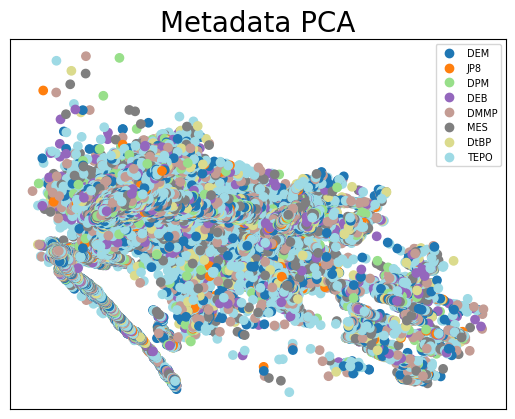

In [ ]:
# scale metadata features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_features_df)
chem_names = list(train['Label'])
plot_metadata_pca(scaled_data, chem_names)

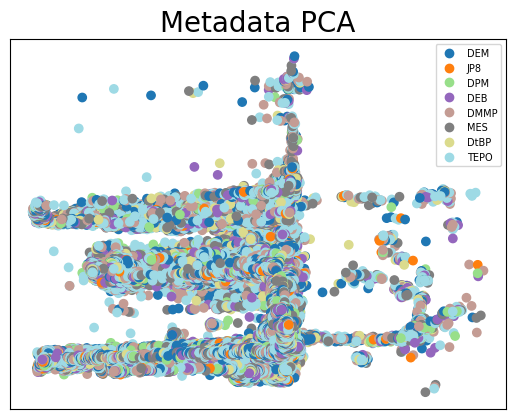

In [71]:
selected_features = ['PosPeak1Mobility', 'PosPeak1Amplitude', 'PressureBar']
selected_features_df = pd.DataFrame()
for feature in selected_features:
    selected_features_df[feature] = numeric_features_df[feature]

chem_names = list(train['Label'])
plot_metadata_pca(selected_features_df, chem_names)

In [96]:
# train_metadata['index'] = train_metadata['level_0']
merged_df = pd.merge(train, train_metadata, left_on='index', right_on='level_0', how='inner')
merged_df.head()

,Unnamed: 0,index_x,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,...,PosPeak1Amplitude,PosPeak2Amplitude,PosPeak3Amplitude,NegPeak1Mobility,NegPeak2Mobility,NegPeak3Mobility,NegPeak1Amplitude,NegPeak2Amplitude,NegPeak3Amplitude,Label_y
0,272149,1297539,94.0,96.0,99.0,101.0,105.0,109.0,115.0,120.0,...,6373.213379,1819.118408,12.000000,2.139164,1.162776,1.476153,6730.377930,13.000000,12.041668,DtBP
1,293336,1344903,108.0,112.0,117.0,122.0,128.0,133.0,138.0,145.0,...,7200.934082,877.818176,29.250000,2.179217,0.672558,1.389953,6101.290527,15.041667,13.250000,DMMP
2,240982,1221071,116.0,122.0,130.0,135.0,143.0,150.0,159.0,167.0,...,7329.604004,149.125000,13.000000,2.197529,1.390181,1.757169,4912.355469,23.125000,15.000000,TEPO
3,226406,1173350,95.0,101.0,106.0,112.0,119.0,124.0,128.0,132.0,...,7583.556152,28.250000,16.041668,2.139312,1.733436,1.393776,7164.287598,38.250000,37.000000,DtBP
4,311847,1416666,105.0,109.0,114.0,119.0,125.0,131.0,138.0,143.0,...,7182.680664,425.041656,9.041666,2.181155,1.705499,1.393301,5925.094727,28.125000,23.041668,TEPO


In [117]:
merged_numeric_features_df.head()

,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,p_193,...,PosPeak3Mobility,PosPeak1Amplitude,PosPeak2Amplitude,PosPeak3Amplitude,NegPeak1Mobility,NegPeak2Mobility,NegPeak3Mobility,NegPeak1Amplitude,NegPeak2Amplitude,NegPeak3Amplitude
0,94.0,96.0,99.0,101.0,105.0,109.0,115.0,120.0,127.0,135.0,...,1.247426,6373.213379,1819.118408,12.000000,2.139164,1.162776,1.476153,6730.377930,13.000000,12.041668
1,108.0,112.0,117.0,122.0,128.0,133.0,138.0,145.0,150.0,156.0,...,1.297900,7200.934082,877.818176,29.250000,2.179217,0.672558,1.389953,6101.290527,15.041667,13.250000
2,116.0,122.0,130.0,135.0,143.0,150.0,159.0,167.0,178.0,187.0,...,1.081462,7329.604004,149.125000,13.000000,2.197529,1.390181,1.757169,4912.355469,23.125000,15.000000
3,95.0,101.0,106.0,112.0,119.0,124.0,128.0,132.0,137.0,140.0,...,1.439129,7583.556152,28.250000,16.041668,2.139312,1.733436,1.393776,7164.287598,38.250000,37.000000
4,105.0,109.0,114.0,119.0,125.0,131.0,138.0,143.0,149.0,154.0,...,1.061851,7182.680664,425.041656,9.041666,2.181155,1.705499,1.393301,5925.094727,28.125000,23.041668


In [123]:
# create df of just numeric features from the merged df
merged_numeric_features = [col for col in merged_df.columns if merged_df[col].dtype == np.float64]
merged_numeric_features_df = merged_df[merged_numeric_features].copy()

# Filling NaNs with col average
means = merged_numeric_features_df.mean()
merged_numeric_features_df.fillna(means, inplace=True)
merged_numeric_features_df.head()

,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,p_193,...,PosPeak3Mobility,PosPeak1Amplitude,PosPeak2Amplitude,PosPeak3Amplitude,NegPeak1Mobility,NegPeak2Mobility,NegPeak3Mobility,NegPeak1Amplitude,NegPeak2Amplitude,NegPeak3Amplitude
0,94.0,96.0,99.0,101.0,105.0,109.0,115.0,120.0,127.0,135.0,...,1.247426,6373.213379,1819.118408,12.000000,2.139164,1.162776,1.476153,6730.377930,13.000000,12.041668
1,108.0,112.0,117.0,122.0,128.0,133.0,138.0,145.0,150.0,156.0,...,1.297900,7200.934082,877.818176,29.250000,2.179217,0.672558,1.389953,6101.290527,15.041667,13.250000
2,116.0,122.0,130.0,135.0,143.0,150.0,159.0,167.0,178.0,187.0,...,1.081462,7329.604004,149.125000,13.000000,2.197529,1.390181,1.757169,4912.355469,23.125000,15.000000
3,95.0,101.0,106.0,112.0,119.0,124.0,128.0,132.0,137.0,140.0,...,1.439129,7583.556152,28.250000,16.041668,2.139312,1.733436,1.393776,7164.287598,38.250000,37.000000
4,105.0,109.0,114.0,119.0,125.0,131.0,138.0,143.0,149.0,154.0,...,1.061851,7182.680664,425.041656,9.041666,2.181155,1.705499,1.393301,5925.094727,28.125000,23.041668


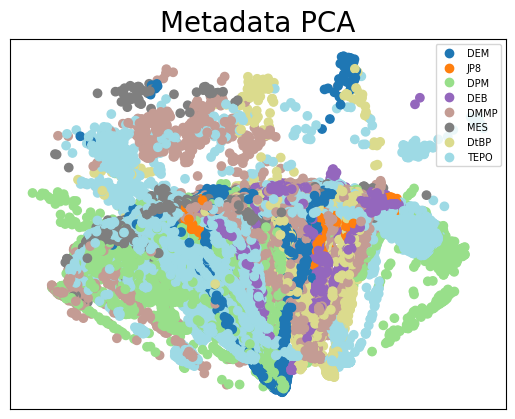

In [126]:
# plot unscaled features
chem_names = list(merged_df['Label_y'])
plot_metadata_pca(merged_numeric_features_df, chem_names)

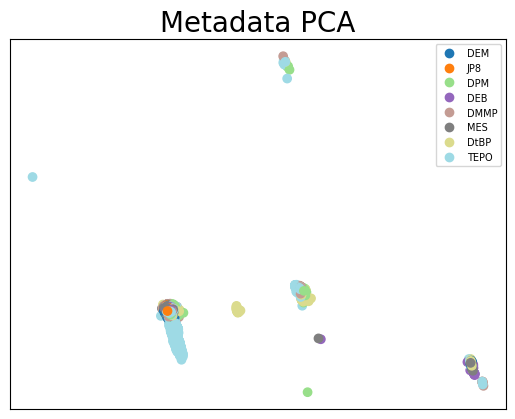

In [127]:
# plot scaled features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_numeric_features_df)
chem_names = list(merged_df['Label_y'])
plot_metadata_pca(scaled_data, chem_names)

In [ ]:
# from sklearn.cluster import KMeans

# clustering_df = numeric_features_df.copy()

# # Applying K-Means
# kmeans = KMeans(n_clusters=3, random_state=42)
# clustering_df['Cluster'] = kmeans.fit_predict(clustering_df)

# # Plotting the results
# plt.scatter(clustering_df['Feature 1'], clustering_df['Feature 2'], c=clustering_df['Cluster'], cmap='viridis')
# plt.title('K-Means Clustering')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()